In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import GridWorld_v5
import draw

import utils

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
class AdvantageActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, env_row, env_column, learning_rate_critic,learning_rate_actor, gamma):
        """
        初始化Advantage Actor-Critic算法
        
        参数:
            state_dim: 状态空间维度
            hidden_dim: 隐藏层维度（在表格型实现中未使用）
            action_dim: 动作空间维度
            env_row: 环境行数
            env_column: 环境列数
            learning_rate_critic: 评论家网络学习率
            learning_rate_actor: 演员网络学习率
            gamma: 折扣因子
        """
        self.action_dim = action_dim  # 动作空间维度
        self.state_dim = state_dim    # 状态空间维度

        self.env_row = env_row        # 环境行数
        self.env_column = env_column  # 环境列数
        
        # 初始化策略表，每个状态的每个动作概率均等
        self.policy_tabular = np.full((env_row * env_column, action_dim), 1/action_dim)
        # 初始化状态值函数表，随机初始化
        self.state_values = np.random.random(env_row * env_column)
        
        self.learning_rate_actor = learning_rate_actor    # 演员学习率
        self.learning_rate_critic = learning_rate_critic  # 评论家学习率
        
        self.gamma = gamma  # 折扣因子
        self.epsilon = 1    # 探索率，用于epsilon-greedy策略

    def take_action(self, state):
        """
        根据当前状态选择动作
        
        参数:
            state: 当前状态，格式为(x,y)坐标
            
        返回:
            选择的动作
        """
        # epsilon-greedy策略：有epsilon概率随机选择动作
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            # 根据当前状态获取动作概率分布
            x, y = state[0], state[1]
            now_frame_probabilities = self.policy_tabular[x * self.env_column + y]
            action = None
            try:
                # 根据概率分布采样动作
                action = np.random.choice(self.action_dim, p=now_frame_probabilities)
            except:
                # 如果采样出错（例如概率和不为1），则随机选择动作
                action = np.random.choice(self.action_dim)
            return action
            
    def softmax(self, logits):
        """
        softmax函数实现
        
        参数:
            logits: 输入的logits值
            
        返回:
            softmax后的概率分布
        """
        exps = np.exp(logits - np.max(logits))  # 为了数值稳定性，可以防止直接计算溢出，从每个logit中减去最大值
        return exps / np.sum(exps)
        
    def update(self, transition_dict):
        """
        更新策略和价值函数
        
        参数:
            transition_dict: 包含轨迹信息的字典，包括状态、动作、奖励、下一状态和终止标志
        """
        reward_list = transition_dict['rewards']          # 奖励列表
        state_list = transition_dict['states']            # 状态列表
        next_state_list = transition_dict['next_states']  # 下一状态列表
        action_list = transition_dict['actions']          # 动作列表
        dones_list = transition_dict['dones']             # 终止标志列表
        
        # 初始化损失记录数组
        losses = [[[] for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)]
                
        # 从后向前遍历轨迹，进行更新
        for i in reversed(range(len(reward_list))):
            # 解析当前步骤的数据
            x, y = state_list[i][0], state_list[i][1] #当前状态的坐标
            nx, ny = next_state_list[i][0], next_state_list[i][1] #下一状态的坐标
            
            # 将二维坐标转换为一维索引
            tmpstate = x * self.env_column + y
            nextState = nx * self.env_column + ny
            
            tmpaction = action_list[i] # 当前动作
            tmpscore = reward_list[i] # 当前奖励
            terminal = dones_list[i] # 终止标志
            
            # Critic更新（评论家网络更新）：计算TD误差并更新状态值函数
            next_state_value = self.state_values[nextState]
            # 计算目标值：当前奖励加上折扣的下一状态价值（如果不是终止状态）
            target = tmpscore + (1.0 - terminal) * self.gamma * next_state_value
            # 计算TD误差
            TD_error = target - self.state_values[tmpstate]
            # 更新状态值函数，为什么是+=因为上面是target - self.state_values[tmpstate]
            self.state_values[tmpstate] += self.learning_rate_critic * TD_error

            # 记录TD误差用于分析
            losses[tmpstate][tmpaction].append(TD_error)
            
            # Actor更新：使用TD误差作为优势函数来更新策略，重点是TD_error
            # 计算策略梯度
            grad = 1 / self.policy_tabular[tmpstate][tmpaction]
            # 更新策略
            self.policy_tabular[tmpstate][tmpaction] += self.learning_rate_actor * grad * TD_error
            
            # 策略规范化：确保概率有效
            # 将概率限制在一个小的正数和1之间
            self.policy_tabular = np.clip(self.policy_tabular, 0.001, 1)
            # 归一化，确保每个状态的动作概率和为1
            self.policy_tabular = self.policy_tabular/self.policy_tabular.sum(axis=1)[:,None]
            # 处理可能的NaN值
            self.policy_tabular = np.nan_to_num(self.policy_tabular, nan=1 / self.action_dim)
            
        # 计算平均损失和总损失（用于分析）
        loss_mean = np.array([[sum(losses[i][j]) / len(losses[i][j]) if len(losses[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        loss_sum = np.array([[sum(losses[i][j]) if len(losses[i][j])!=0 else 0 for j in range(self.action_dim)] for i in range(self.env_column * self.env_row)])
        loss = loss_mean
        self.loss = loss

In [3]:
def train(hyperparameters, img_path):
    rows = 5      # 定义环境的行数
    columns = 5   # 定义环境的列数
    
    forbiddenAreaScore = hyperparameters['forbiddenAreaScore']  # 获取禁区惩罚分数
    targetAreaScore = hyperparameters['targetAreaScore']        # 获取目标区域奖励分数
    hitWallScore = hyperparameters['hitWallScore']              # 获取撞墙惩罚分数
    moveScore = hyperparameters['moveScore']                    # 获取移动惩罚分数
    start_state = hyperparameters['start_state']                # 获取起始状态
    action_space = hyperparameters['action_space']              # 获取动作空间大小
    learning_rate_critic = hyperparameters['learning_rate_critic']  # 获取评论家学习率
    learning_rate_actor = hyperparameters['learning_rate_actor']    # 获取演员学习率
    num_episodes = hyperparameters['num_episodes']              # 获取训练回合数
    hidden_dim = hyperparameters['hidden_dim']                  # 获取隐藏层维度
    gamma = hyperparameters['gamma']                            # 获取折扣因子
    
    env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
                                    desc = [".....",".##..","..#..",".#T#.",".#..."]) # 创建网格世界环境，设置初始状态、奖励和地图描述
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#..T",
    #                                         ".....#."]) # 备选环境配置（已注释）
    
    # env = GridWorld_v5.GridWorld_v5(initState=start_state, moveScore=moveScore, action_space=action_space, forbiddenAreaScore=forbiddenAreaScore, score=targetAreaScore, hitWallScore = hitWallScore,
    #                                 desc = ["...#...",
    #                                         ".....#T"]) # 另一个备选环境配置（已注释）
    
    agent = AdvantageActorCritic(state_dim = env.get_observation_space(), 
              hidden_dim = hidden_dim, 
              action_dim = env.get_action_space(), 
              env_row = env.rows, 
              env_column = env.columns, 
              learning_rate_actor = learning_rate_actor, 
              learning_rate_critic = learning_rate_critic,
              gamma = gamma)  # 创建Advantage Actor-Critic智能体
    print(agent)  # 打印智能体信息
    return_list = []  # 初始化回报列表

    epsilon = 0.15  # 初始探索率
    final_epsilon = 0.01  # 最终探索率
    pbar = tqdm(range(num_episodes))  # 创建进度条
    for i in pbar:# 10000  # 循环训练指定回合数
        if(epsilon > final_epsilon) :  # 如果当前探索率大于最终探索率
            epsilon -= hyperparameters['gamma_minus_each_episodes']  # 减小探索率
        else:
            epsilon = final_epsilon  # 否则保持最终探索率
        agent.epsilon = epsilon  # 更新智能体的探索率

        episode_return = 0  # 初始化当前回合的累积回报
        transition_dict = {  # 初始化转移字典
            'states': [],
            'actions': [],
            'next_states': [],
            'rewards': [],
            'dones': []
        }
        state = env.reset()  # 重置环境，获取初始状态
        done = False  # 初始化终止标志
        cnt = 0  # 初始化步数计数器
        while not done:  # 当回合未结束时
            cnt = cnt + 1  # 步数加1
            action = agent.take_action(state)  # 智能体选择动作
            next_state, reward, done, _ = env.step(action)  # 执行动作，获取下一状态、奖励和终止标志
            transition_dict['states'].append(state)  # 记录当前状态
            transition_dict['actions'].append(action)  # 记录当前动作
            transition_dict['next_states'].append(next_state)  # 记录下一状态
            transition_dict['rewards'].append(reward)  # 记录奖励
            transition_dict['dones'].append(done)  # 记录终止标志
            state = next_state  # 更新当前状态
            episode_return += reward  # 累加回报

            # if episode_return <= forbiddenAreaScore*2:
            #     break  #如果被惩罚了两次，那么就跳出迭代，开始扣分！！

            if cnt>hyperparameters['exploring_step']:  # 如果步数超过最大探索步数
                break  # 结束当前回合
            
        return_list.append(episode_return)  # 记录当前回合的累积回报
        pre_frame_probabilities = agent.policy_tabular.copy()  # 保存更新前的策略概率

        agent.update(transition_dict)  # 更新智能体

        now_frame_probabilities = agent.policy_tabular  # 获取更新后的策略概率
        pbar.set_postfix({"epsilon": epsilon})  # 更新进度条显示的探索率
        if i % 300 == 0:  # 每300回合
            state_values = agent.state_values  # 获取状态值
            p = np.argmax(agent.policy_tabular,axis=1)  # 获取每个状态的最优动作
            draw.draw(state_values.reshape(5,5), p)  # 绘制状态值和策略
            draw.plot_policy(pre_frame_probabilities, now_frame_probabilities, agent.loss , transition_dict['states'], env.get_map_description(), img_path)  # 绘制策略变化、损失和轨迹

experiments/Penalty-100_Score50_State(0~24)/Penalty-100_Score50_State10


  0%|          | 0/2100 [00:00<?, ?it/s, epsilon=0.15]

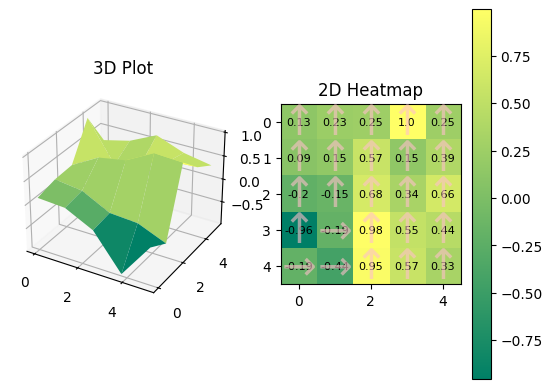

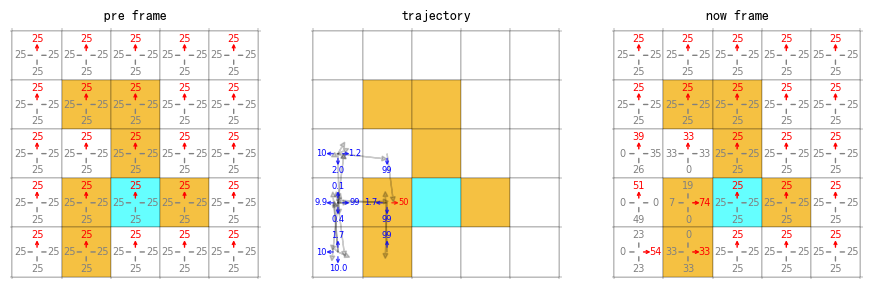

 14%|█▎        | 286/2100 [00:01<00:05, 355.40it/s, epsilon=0.147]

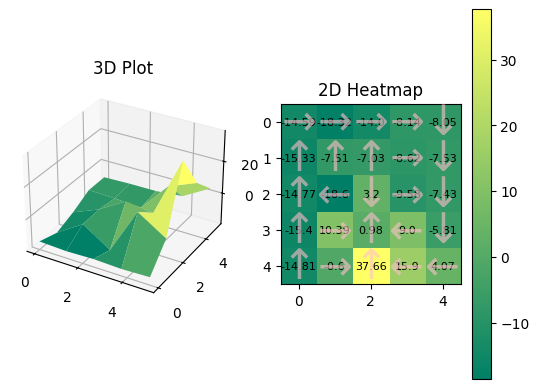

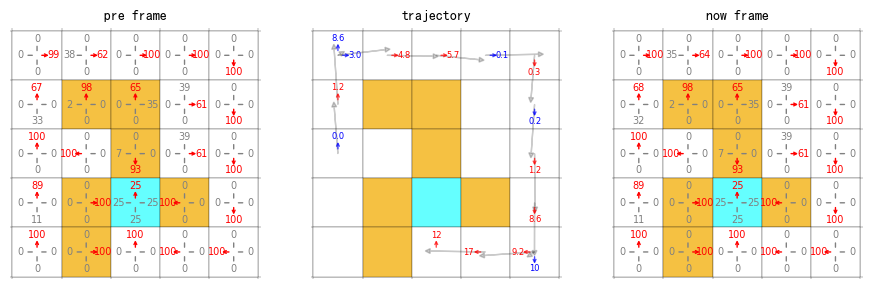

 27%|██▋       | 571/2100 [00:03<00:05, 295.02it/s, epsilon=0.144]

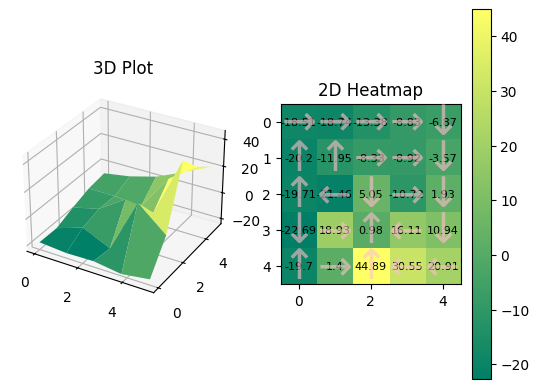

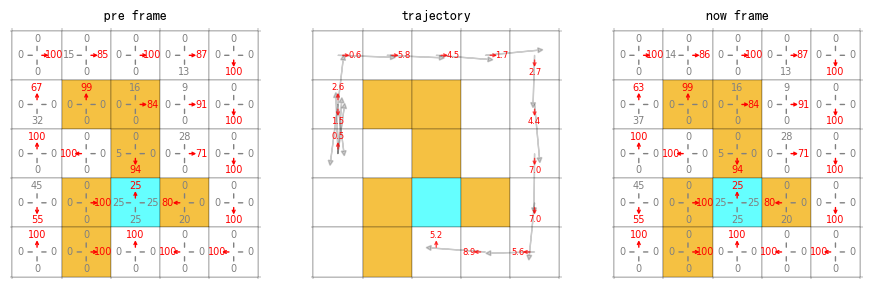

 41%|████      | 855/2100 [00:05<00:04, 287.86it/s, epsilon=0.141]

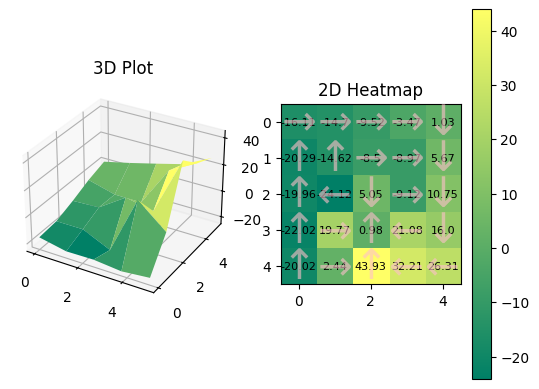

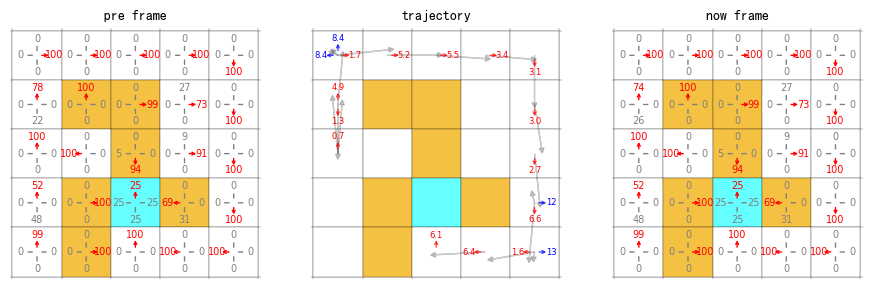

 57%|█████▋    | 1198/2100 [00:06<00:02, 343.34it/s, epsilon=0.138]

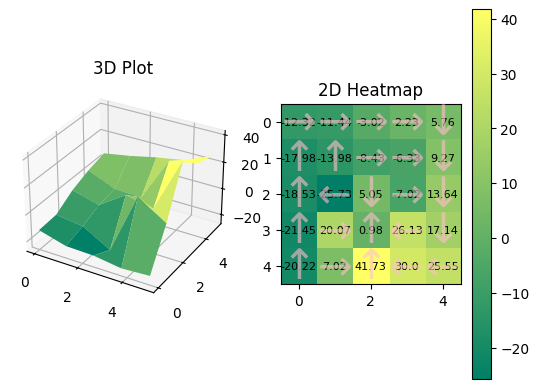

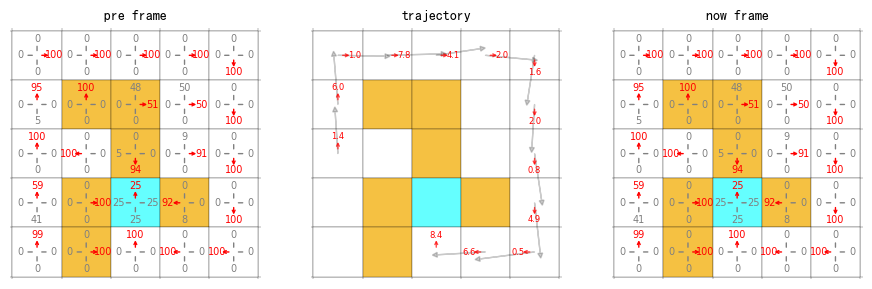

 71%|███████   | 1490/2100 [00:08<00:02, 297.52it/s, epsilon=0.135]

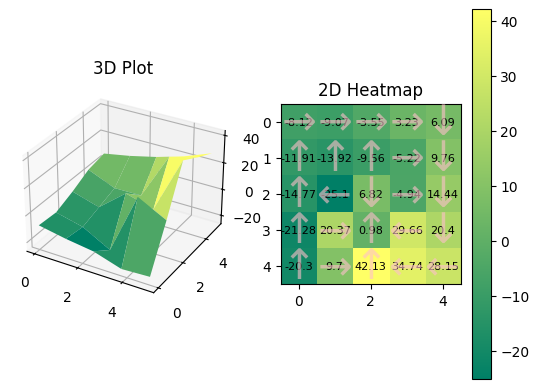

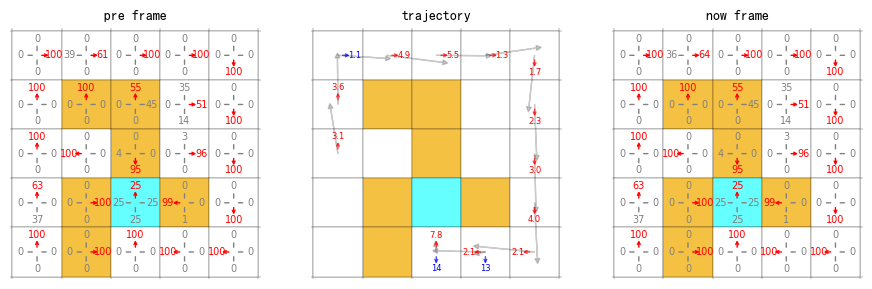

 85%|████████▌ | 1790/2100 [00:09<00:00, 312.20it/s, epsilon=0.132]

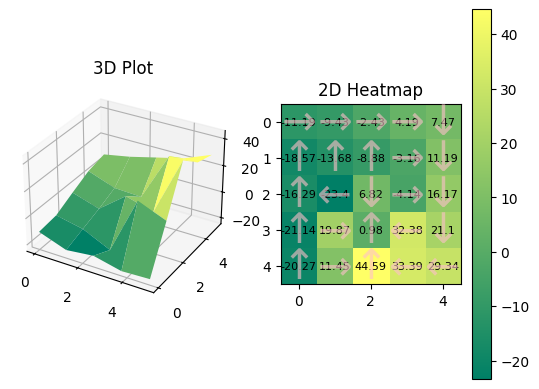

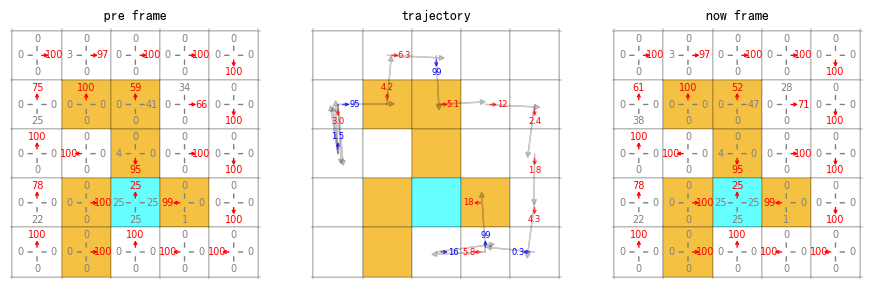

100%|██████████| 2100/2100 [00:11<00:00, 180.48it/s, epsilon=0.129]


In [4]:
hyperparameters = {
    'forbiddenAreaScore': -100,  # 踩陷阱和碰壁的惩罚
    'hitWallScore': -10,         # 撞墙的惩罚分数
    'targetAreaScore': 50,       # 到达目标区域的奖励
    'moveScore': -1,             # 每次移动的惩罚（鼓励尽快到达目标）
    'action_space': 4,           # 动作空间大小（上、右、下、左）
    'learning_rate_critic': 0.01,# 评论家网络的学习率
    'learning_rate_actor': 0.01, # 演员网络的学习率
    'hidden_dim': 512,           # 神经网络隐藏层维度，没有用这个
    'gamma': 0.9,                # 折扣因子，用于计算未来奖励的现值
    'num_episodes': 2100,        # 训练轮次，每次训练epsilon -= gamma_minus_each_episodes
    'start_state': 10,           # 起始状态编号
    'gamma_minus_each_episodes':0.00001, # 每轮训练后探索率的衰减值
    'exploring_step':50          # 每轮最大探索步数
}

start_state = hyperparameters['start_state']  # 从超参数中获取起始状态

# 创建 images 文件夹（如果不存在）
experiment_name = f"Penalty{hyperparameters['forbiddenAreaScore']}_Score{hyperparameters['targetAreaScore']}_State"  # 根据惩罚和奖励创建实验名称
output_dir = f"experiments/{experiment_name}(0~24)/"  # 设置输出目录路径
if not os.path.exists(output_dir):  # 如果输出目录不存在
    os.makedirs(output_dir)  # 创建输出目录
# 图片文件路径

img_name = f"{experiment_name}{start_state}"  # 创建图片名称，包含实验名和起始状态
img_path = os.path.join(output_dir, img_name)  # 组合完整的图片路径
xlsx_path = os.path.join(output_dir, experiment_name+".xlsx")  # 组合完整的Excel文件路径
print(img_path)  # 打印图片路径
train(hyperparameters, img_path)  # 使用设定的超参数和图片路径开始训练

utils.write_excel(hyperparameters ,img_path+'.png', bias = start_state, xlsx_path=xlsx_path, highlights=['start_state'])  # 将训练结果写入Excel文件
